# Heat Kernel Generation and Analysis

Given frames of locally normalized residue-residue pairwise energetic matrices, this step in the pipeline generates the heat kernel, provides the ability to determine the optimal cutoff and time values, then applies PCA on the reference data. Once these values are determined, the same values are used to generate the heat kernel and PCA of all other constructs being studied.

Modified by Sean Stetson on Oct 31, 2024.

In [1]:
#Edit these to suit your system: 
NUM_FRAMES = 6000     # Number of frames per construct
NUM_RESIDUES = 393

# Path to matrix data
path = "/home/student5/Desktop/Energetics/zfshomes/sstetson/End_Fall23-Pres/Analysis/FL/ff14SB/Energetics/"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from kneed import KneeLocator as KneedLoc
from sklearn.decomposition import PCA
from itertools import chain

plt.rcParams["font.family"] = "Helvetica"

In [3]:
# %matplotlib widget

## Load and Process Data

In [4]:
def LoadData(file: str) -> np.array:
    """
    `file` contains the location to a .npz file. The data from the file is read in, and returned as a np.array.
    The file `file` points to is expected to only contain a single n x n array, an error is thrown if this is not true,
    since this means that means there is some sort of problem.  
    """
    toReturn = []
    with np.load(file) as data:
        lst = data.files
        for item in lst:
            toReturn.append(data[item])
    if len(toReturn) > 1: raise ValueError(f"file has length {len(toReturn)}")
    return toReturn[0]
    
def ThresholdNormalizedGraph(matrix: np.array, cutoff: float):
    """
    Given an n x n np.array (`matrix`), uses the provided `cutoff` to threshold all values lower than the cutoff to 
    zero. The input array is expected to already be normalized, which should be true if the matrix was generated
    by the pairwise energetic calculation and thresholding script written by Sean Stetson.
    """
    size = matrix.shape[0]
    newMatrix = np.zeros((size, size))
    for x, row in enumerate(matrix):
        for y, val in enumerate(row):
            newMatrix[x, y] = matrix[x, y] if matrix[x, y] > cutoff else 0

    return newMatrix

def TestThresh(data: np.ndarray, construct: str, binWidth: float = 0.001, thresh: float = None, hideAbove = 0.04) -> None:
    """
    Given a np.ndarray (`data`), plots a histogram of edge weights so that the user may identify their cutoff point.
    `construct` is a description of the construct being plotted, used in the title of the graph and file path of the image.
    `binWidth` controls the width of the bins used in the histogram plot.
    `thresh` is a proposed threshold value, if provided, is plotted as a vertical line along with the histogram to illustrate
    what data will be cut off.
    `hideAbove` hides all data above the value, which reduces visual clutter in the histogram. 
    """
    fig, ax = plt.subplots(layout = "constrained")
    d = data.flatten()
    d = d[d < hideAbove] # Some values exist beyone this range but aren"t relevant for this step
    x = ax.hist(d, bins = int((np.max(d) - np.min(d)) / binWidth))
    ax.set_xlabel("Normalized Edge Weight Value")
    ax.set_ylabel("Number of Edges")
    if thresh: ax.vlines([thresh], 0, 1, colors = "red", linestyles = "-", transform = ax.get_xaxis_transform())
    fig.suptitle(f"{construct} Distribution of Edge Weight: Thresh = {thresh}", fontsize=10)
    plt.savefig(f"{construct}_EdgeWeightDist.png", bbox_inches = "tight", dpi = 300, transparent = False, facecolor = "white")

## Heat Kernel Analysis
See https://link.springer.com/chapter/10.1007/11815921_18 for detailed explanation

In [5]:
def MatrixExponentiation(eigenvectors, eigenvalues, t):
    """
    Raise e^matrix where matrix is a square
    """
    shape = eigenvectors.shape[0]
    processedEigenvalues = np.exp(-t*eigenvalues)
    e_diagonal = np.diag(processedEigenvalues)
    return eigenvectors.dot(e_diagonal).dot(eigenvectors.transpose())

def GetHeatKernel(matrix: np.array, t: float) -> np.array:
    """
    Computes the heat kernel for a specific matrix and time value
    """
    laplacian = scipy.sparse.csgraph.laplacian(matrix, normed = True)
    (eigenvalues, eigenvectors) = np.linalg.eigh(laplacian)
    x = MatrixExponentiation(eigenvectors, eigenvalues, t)
    x = np.round(x, decimals = 6)
    return x

def KernelFromEnergyTensorThresh(tensor: np.ndarray, threshold: float, time: float) -> np.ndarray:
    """
    Given a data tensor (`tensor`), the threshold value (`threshold`), and the time value (`time`),
    computes the heat kernel. 
    """
    kernels = np.zeros((tensor.shape[0], tensor.shape[1], tensor.shape[2]))
    for i, matrix in enumerate(tensor):
        thresholded = ThresholdNormalizedGraph(matrix, threshold)
        kernel = GetHeatKernel(thresholded, time)
        kernels[i] = kernel

    return kernels

## PCA

In [6]:
def GetPCA(kernel: np.ndarray, dim: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Computes the PC decomposition of `kernel` with `dim` number of components.
    Returns the transformed data and the explained variance of the data.
    """
    pca = PCA(n_components = dim)
    pca.fit(kernel)
    transformed = pca.transform(kernel)
    return (transformed, pca.explained_variance_)

def MakePCA_DF(kernels: np.ndarray, numComponents: int, showVar: bool = False) -> tuple[np.ndarray | None, np.ndarray]:
    """
    Given a tensor of heat kernel data, computes the PC decomposition of each element with
    `numComponents` number of components. Returns the explained variance if `showVar == True`,
    and None otherwise, and returns the transformed tensor.
    """
    dfs = []
    eigens = []
    for kernel in kernels:
        (pcs, var) = GetPCA(kernel, numComponents)
        dfs.append(pd.DataFrame(pcs))
        if showVar:
            eigens += [var]

    return (eigens, pd.concat(dfs))

## Format Output

In [7]:
def AssignResNum(numFrames: int, numRes: int, df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a dataframe, adds the column "res" to it, which keeps track of residue number.
    The precondition is that the dataframe is organized such that it lists all resides
    in increasing order for frame 1, then frame 2, and so on. Returns the modified dataframe.
    """
    df["res"] = (list(range(numRes)) * numFrames)
    return df

def AssignFrameNum(numFrames: int, numRes: int, df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a dataframe, adds the column "frame" to it, which keeps track of the frame number.
    The precondition is that the dataframe is organized such that it lists all resides
    in increasing order for frame 1, then frame 2, and so on. Returns the modified dataframe.
    """
    framesList = [[x] * numRes for x in range(numFrames)]
    df["frame"] = list(chain(*framesList)) # unpacks the nested list
    return df

def MapToHeat(kernel: np.ndarray, df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a dataframe, adds the column "heat" to it, which keeps track of the heat value.
    The precondition is that the dataframe is organized such that it lists all resides
    in increasing order for frame 1, then frame 2, and so on. Returns the modified dataframe.
    """
    diagEls = []
    for matrix in kernel[:]:
        diagElement = np.diag(matrix)
        diagEls += [diagElement]
    diagFlat = np.concatenate(diagEls)
    #set the column called "heat" to the flattened diagonal matrix consisting of the diagonal elements of the kernel
    df["heat"] = diagFlat
    return df

def mapPCsToHeatRes(pcs: pd.DataFrame, kernel: np.ndarray) -> pd.DataFrame:
    """
    Given a dataframe that contains the PC data of the heat kernel, adds
    the columns "res", "frame", and "heat".
    Returns the modified dataframe.
    """
    pcs = pcs.copy()
    
    pcs = MapToHeat(kernel, pcs)
    
    pcs["res"] = [x + 1 for x in (list(range(NUM_RESIDUES)) * NUM_FRAMES)]
    
    framesList = [[x] * NUM_RESIDUES for x in range(NUM_FRAMES)]
    pcs["frame"] = list(chain(*framesList)) # unpacks the nested list

    return pcs

## Determine Cutoff, Time Values for Reference System

In [9]:
etensor = [
    LoadData(path + f"Rep1/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 1001)
] + [
    LoadData(path + f"Rep2/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 1001)
] + [
    LoadData(path + f"Rep3/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 1001)
] + [
    LoadData(path + f"Rep4/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 1001)
] + [
    LoadData(path + f"Short/Rep1/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"Short/Rep2/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"Short/Rep3/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"Short/Rep4/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"Short/Rep5/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"Short/Rep6/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"Short/Rep7/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"Short/Rep8/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"Short/Rep9/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
] + [
    LoadData(path + f"Short/Rep10/WT/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
]

etensor = np.array(etensor) #etensor indexing: frame, row, column
etensor

array([[[0.        , 0.01327499, 0.01161556, ..., 0.00240205,
         0.00159166, 0.00283909],
        [0.01327499, 0.        , 0.01312647, ..., 0.00251648,
         0.00221125, 0.00305427],
        [0.01161556, 0.01312647, 0.        , ..., 0.00250009,
         0.00219331, 0.0029989 ],
        ...,
        [0.00240205, 0.00251648, 0.00250009, ..., 0.        ,
         0.01549334, 0.01476951],
        [0.00159166, 0.00221125, 0.00219331, ..., 0.01549334,
         0.        , 0.0181178 ],
        [0.00283909, 0.00305427, 0.0029989 , ..., 0.01476951,
         0.0181178 , 0.        ]],

       [[0.        , 0.01225248, 0.01103093, ..., 0.00247762,
         0.0016766 , 0.00302596],
        [0.01225248, 0.        , 0.01403142, ..., 0.00264167,
         0.00234268, 0.00333519],
        [0.01103093, 0.01403142, 0.        , ..., 0.00254145,
         0.00220687, 0.00318794],
        ...,
        [0.00247762, 0.00264167, 0.00254145, ..., 0.        ,
         0.01856716, 0.01471809],
        [0.0

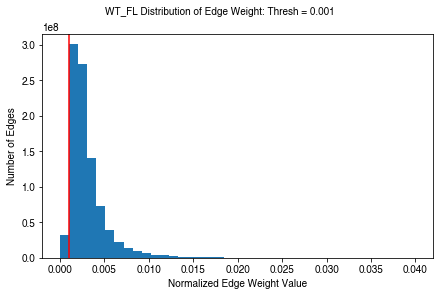

In [10]:
TestThresh(etensor, "WT_FL", thresh = 0.003)

### Creating thresholded and normalized matrices of the energy tensors:
##### This is done to check where we might want to cut off values in our subsequent tensor generation

### Determining Time and Thresh Parameters

In [11]:
TIME = 5
THRESH = 0.003
numPCsToTest = 15

kernel = KernelFromEnergyTensorThresh(etensor, THRESH, TIME)
variance, pcs = MakePCA_DF(kernel, numPCsToTest, showVar = True)

varianceDF = pd.DataFrame(variance)
meanVariance = varianceDF.mean(axis = 0)

Elbow Eigenvalue: 2


/tmp/ipykernel_39828/867390808.py:7: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("FL_WT_PCA_Knee.png", bbox_inches = "tight", dpi = 300)
/home/student5/anaconda3/envs/AmberTools23/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


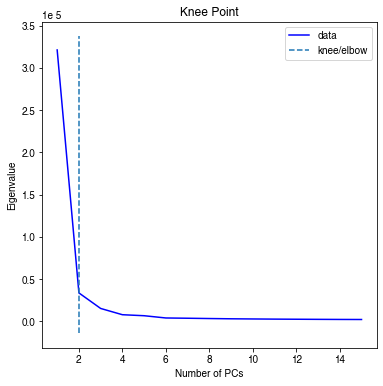

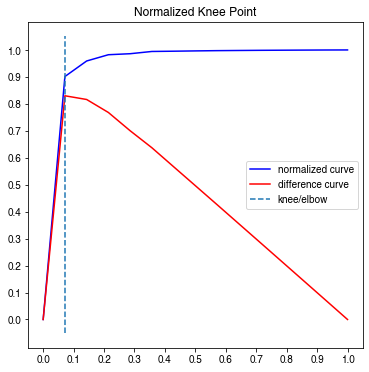

In [12]:
kneedl= KneedLoc(range(1, numPCsToTest+1), meanVariance, S = 1, curve = "convex", direction = "decreasing")
print("Elbow Eigenvalue:", round(kneedl.elbow, 3))
kneedl.plot_knee()
ax = plt.gca()
ax.set_xlabel("Number of PCs")
ax.set_ylabel("Eigenvalue")
plt.savefig("FL_WT_PCA_Knee.png", bbox_inches = "tight", dpi = 300)
kneedl.plot_knee_normalized()
plt.savefig("FL_WT_PCA_KneeDiff.png", bbox_inches = "tight", dpi = 300)

In [13]:
OPTIMAL_PCs = int(round(kneedl.elbow, 3))
df = pcs[list(range(OPTIMAL_PCs))]
df

,0,1
0,-0.004033,0.003265
1,-0.000505,0.003553
2,-0.000212,0.004053
3,-0.005428,0.003104
4,0.001346,0.003980
...,...,...
388,-0.005184,0.001581
389,-0.005179,0.001552
390,-0.002607,0.001739
391,-0.004540,0.001535


In [14]:
pcsHeatRes = mapPCsToHeatRes(df, kernel)
pcsHeatRes.to_csv("/home/student5/Desktop/Energetics/Processed/FL_WT_Long+Short_Elec_1-393.csv", index=False)
pcsHeatRes

,0,1,heat,res,frame
0,-0.004033,0.003265,0.009022,1,0
1,-0.000505,0.003553,0.009371,2,0
2,-0.000212,0.004053,0.009487,3,0
3,-0.005428,0.003104,0.008919,4,0
4,0.001346,0.003980,0.009608,5,0
...,...,...,...,...,...
388,-0.005184,0.001581,0.008890,389,5999
389,-0.005179,0.001552,0.008884,390,5999
390,-0.002607,0.001739,0.009100,391,5999
391,-0.004540,0.001535,0.008948,392,5999


## Generate Heat Kernel PCA Data for All Other Constructs Using Above Values

In [ ]:
for construct in ["WT_PK11000", "Y220C", "Y220C_PK11000"]:
    etensor = [
        LoadData(path + f"Rep1/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 1001)
    ] + [
        LoadData(path + f"Rep2/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 1001)
    ] + [
        LoadData(path + f"Rep3/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 1001)
    ] + [
        LoadData(path + f"Rep4/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 1001)
    ] + [
        LoadData(path + f"Short/Rep1/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
    ] + [
        LoadData(path + f"Short/Rep2/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
    ] + [
        LoadData(path + f"Short/Rep3/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
    ] + [
        LoadData(path + f"Short/Rep4/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
    ] + [
        LoadData(path + f"Short/Rep5/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
    ] + [
        LoadData(path + f"Short/Rep6/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
    ] + [
        LoadData(path + f"Short/Rep7/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
    ] + [
        LoadData(path + f"Short/Rep8/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
    ] + [
        LoadData(path + f"Short/Rep9/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
    ] + [
        LoadData(path + f"Short/Rep10/{construct}/normal/elec_1-393/elec_{x}.npz") for x in range(1, 201)
    ]

    etensor = np.array(etensor) #etensor indexing: frame, row, column

    kernel = KernelFromEnergyTensorThresh(etensor, THRESH, TIME)
    _, pcs = MakePCA_DF(kernel, OPTIMAL_PCs, showVar = True)

    pcsHeatRes = mapPCsToHeatRes(pcs, kernel)
    pcsHeatRes.to_csv(f"/home/student5/Desktop/Energetics/Processed/FL_{construct}_Long+Short_Elec_1-393.csv", index=False)